In [15]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
# from skimage.measure import regionprops_table
# from skimage.transform import rescale, resize
# from skimage.filters import gaussian
# from skimage.exposure import rescale_intensity
# from skimage.measure import regionprops

import squidpy as sq
import tifffile as tf

import numpy as np
import matplotlib.pyplot as plt

from re import sub
from cellpose_gaussian import *


In [16]:
def get_image_CHW(
    img,
    layer="image",
    library_id=None,  # pick one if you have multiple libraries
    scale=None,       # pick pyramid level; 0 or the smallest scale index is usually highest-res
    compute=True,     # compute dask arrays to NumPy
):
    da: xr.DataArray = img[layer]

    # Select library if present
    if "library_id" in da.dims:
        if library_id is None:
            library_id = da.coords["library_id"].values[0]
        da = da.sel(library_id=library_id)

    # Select scale (pyramid level) if present
    if "scale" in da.dims:
        if scale is None:
            scale = int(da.coords["scale"].values.min())
        da = da.sel(scale=scale)

    # Materialize to NumPy
    if compute and hasattr(da.data, "compute"):  # dask-backed
        arr = da.data.compute()
    else:
        arr = da.to_numpy()

    # Squeeze stray singleton dims (but keep y/x/channels)
    # safer to squeeze only dims not named y/x/channels
    keep = {"y", "x", "channels"}
    for d in list(da.dims):
        if d not in keep and da.sizes.get(d, 1) == 1:
            da = da.isel({d: 0})
    # re-materialize if dims changed
    if compute and hasattr(da.data, "compute"):
        arr = da.data.compute()
    else:
        arr = da.to_numpy()

    # Now normalize to (C, H, W)
    dims = list(da.dims)

    if arr.ndim == 2:
        # (H, W) → (1, H, W)
        arr = arr[None, ...]
        C, H, W = arr.shape
        return arr

    if arr.ndim == 3:
        # Use dims if available
        if "channels" in dims:
            c_axis = dims.index("channels")
            if c_axis != 0:
                arr = np.moveaxis(arr, c_axis, 0)
            return arr  # (C, H, W)
        # If dims don’t name channels, infer:
        # Heuristic: channel axis is the one with the smallest size (often <= 8)
        c_axis = int(np.argmin(arr.shape))
        # but if the smallest axis is very large (e.g., no channels), assume channels-last
        if arr.shape[c_axis] > 16 and dims == ["y", "x", "z"]:
            # unlikely, but handle as needed
            pass
        if c_axis != 0:
            arr = np.moveaxis(arr, c_axis, 0)
        return arr

    if arr.ndim == 4:
        # Often something like (Z, Y, X, C) or (S, Y, X, C). Pick first along extra axis.
        # Prefer dims to decide:
        if "channels" in dims:
            c_axis = dims.index("channels")
            # choose first index over any extra non y/x/channels dims
            for i, d in enumerate(dims):
                if d not in ("y", "x", "channels"):
                    da = da.isel({d: 0})
            arr = da.to_numpy()
            # move channels to 0
            if c_axis != 0:
                arr = np.moveaxis(arr, c_axis, 0)
            return arr
        else:
            # Fallback: assume last is channels, first is an extra axis -> take first slice
            arr = arr[0]
            # now handle like 3D case:
            if arr.ndim != 3:
                raise ValueError(f"Unexpected 4D layout after slicing: shape={arr.shape}, dims={dims}")
            # infer channel axis
            c_axis = int(np.argmin(arr.shape))
            if c_axis != 0:
                arr = np.moveaxis(arr, c_axis, 0)
            return arr

    raise ValueError(f"Unsupported image shape {arr.shape} with dims {dims}")



def _to_numpy_hwC(img, layer="image"):
    """Return image as (H, W, C); select z=0 if present; materialize dask."""
    da = img[layer]
    if "z" in da.dims:
        da = da.isel(z=0)
    # materialize
    arr = da.data.compute() if hasattr(da.data, "compute") else da.values
    # ensure channels-last
    dims = list(da.dims)
    if "channels" in dims:
        c_ax = dims.index("channels")
        if c_ax != arr.ndim - 1:
            arr = np.moveaxis(arr, c_ax, -1)
    elif arr.ndim == 2:
        arr = arr[..., None]
    elif arr.ndim != 3:
        raise ValueError(f"Unsupported array ndim {arr.ndim} from dims {dims}")
    return arr

def _add_layer_from_hwC(img, arr, layer_name):
    """Add (H, W, C) array back as a new ImageContainer layer."""
    img.add_img(arr, layer=layer_name, dims=("y", "x", "channels"))

def reduce_resolution_same_size_ic(
    img,
    in_layer="image",
    out_layer="image_lowres",
    factor=0.25,          # downsample factor (0.25 => 4× less detail)
    pre_blur_sigma=None,  # optional blur before downsampling
    grayscale_first=False,
    gray_channel=0,       # which channel to keep if grayscale_first=True
):
    """
    Lower effective resolution via down->up sampling while keeping (H, W) unchanged.
    Writes result to `out_layer` in the same ImageContainer.
    """
    arr = _to_numpy_hwC(img, in_layer)          # (H, W, C)
    H, W, C = arr.shape
    orig_dtype = arr.dtype

    # Optional grayscale collapse first
    if grayscale_first:
        arr = arr[..., gray_channel:gray_channel+1]  # (H, W, 1)

    # Optional pre-blur to avoid aliasing artifacts
    if pre_blur_sigma is not None and pre_blur_sigma > 0:
        arr = gaussian(arr, sigma=pre_blur_sigma, channel_axis=-1, preserve_range=True)

    # Downsample then upsample back to original size (keeps H,W the same)
    h_small = max(1, int(round(H * factor)))
    w_small = max(1, int(round(W * factor)))
    low = resize(arr, (h_small, w_small, arr.shape[2]), anti_aliasing=True, preserve_range=True)
    up  = resize(low, (H, W, arr.shape[2]), anti_aliasing=True, preserve_range=True)

    # Cast back to original dtype / range
    if np.issubdtype(orig_dtype, np.integer):
        up = np.clip(np.rint(up), 0, np.iinfo(orig_dtype).max).astype(orig_dtype)
    else:
        up = up.astype(orig_dtype)

    _add_layer_from_hwC(img, up, out_layer)
    return out_layer



def blur_and_boost_contrast(img_arr, sigma=5, stretch=True):
    blurred = gaussian(img_arr, sigma=sigma, channel_axis=-1, preserve_range=True)
    if stretch:
        blurred = rescale_intensity(blurred, in_range="image", out_range="dtype")
    return blurred.astype(img_arr.dtype)



def extract_arr_to_df(
    img,
    img_layer="image",
    seg_layer="segmented_watershed",
    area_percentile=0.95,
):
    """
    Extract geometric and per-channel intensity features from a segmented image,
    while removing small objects based on an area percentile threshold.

    This function:
    1. Loads a multi-channel image array in (C, H, W) format.
    2. Loads a 2-D labeled segmentation image (H, W).
    3. Computes region areas and removes objects whose area falls below
       the specified percentile threshold.
    4. Recomputes geometric properties and per-channel intensity statistics
       using only the retained (large) objects.
    5. Returns the image array, filtered label image, and a combined DataFrame
       of region properties.

    Parameters
    ----------
    img : xarray.Dataset
        Input dataset containing the image and segmentation layers.
    img_layer : str, default "image"
        Name of the image layer in `img`.
        Expected shape after loading: (C, H, W).
    seg_layer : str, default "segmented_watershed"
        Name of the segmentation layer in `img`.
        Must contain labeled regions (integer labels, background = 0).
    area_percentile : float, default 0.95
        Percentile (0–1) used to filter objects by area.
        Only objects with area >= this percentile are retained.
        Example:
            0.95 → keep top 5% largest objects
            0.90 → keep top 10% largest objects

    Returns
    -------
    arr : np.ndarray
        Image array with shape (C, H, W).
    labels_filtered : np.ndarray
        Filtered label image (H, W) with small objects removed (set to 0).
    df : pandas.DataFrame
        DataFrame containing geometric and per-channel intensity properties
        for retained objects only.

    Notes
    -----
    - Label values are preserved but may be non-contiguous after filtering.
    - Background is assumed to be labeled as 0.
    - All intensity statistics are computed *after* small objects are removed.
    """



    # ------------------------------------------------------------
    # Load image array (C, H, W)
    # ------------------------------------------------------------
    arr = get_image_CHW(img, layer=img_layer)

    # ------------------------------------------------------------
    # Load segmentation labels and align coordinates if needed
    # ------------------------------------------------------------
    labels = img[seg_layer]

    if "library_id" in labels.dims and "library_id" in img[img_layer].dims:
        labels = labels.sel(
            library_id=img[img_layer].coords["library_id"].values[0]
        )

    if "scale" in labels.dims and "scale" in img[img_layer].dims:
        labels = labels.sel(
            scale=img[img_layer].coords["scale"].values.min()
        )

    # Materialize labels as NumPy array
    labels = (
        labels.data.compute()
        if hasattr(labels.data, "compute")
        else labels.to_numpy()
    )
    labels = np.asarray(labels).squeeze()

    if labels.ndim != 2:
        raise ValueError(
            f"Expected labels to be 2-D (H, W); got {labels.shape}"
        )

    # ------------------------------------------------------------
    # Compute initial region areas
    # ------------------------------------------------------------
    area_df = pd.DataFrame(
        regionprops_table(labels, properties=["label", "area"])
    )

    if area_df.empty:
        # No regions found
        return arr, labels, pd.DataFrame()

    # ------------------------------------------------------------
    # Determine area threshold and retain large objects
    # ------------------------------------------------------------
    area_threshold = area_df["area"].quantile(area_percentile)
    keep_labels = area_df.loc[
        area_df["area"] >= area_threshold, "label"
    ].values

    # Zero out small objects in label image
    labels_filtered = np.where(
        np.isin(labels, keep_labels), labels, 0
    )

    # ------------------------------------------------------------
    # Compute geometric properties on filtered labels
    # ------------------------------------------------------------
    geom_props = [
        "label",
        "area",
        "perimeter",
        "eccentricity",
        "solidity",
        "bbox_area",
        "major_axis_length",
        "minor_axis_length",
        "orientation",
        "centroid",
    ]

    geom_df = pd.DataFrame(
        regionprops_table(labels_filtered, properties=geom_props)
    )

    # ------------------------------------------------------------
    # Compute per-channel intensity statistics
    # ------------------------------------------------------------
    dfs = [geom_df]

    for c in range(arr.shape[0]):
        intensity_props = [
            "mean_intensity",
            "min_intensity",
            "max_intensity",
        ]

        t = regionprops_table(
            labels_filtered,
            intensity_image=arr[c],
            properties=["label"] + intensity_props,
        )

        ch_df = (
            pd.DataFrame(t)
            .drop(columns=["label"])
            .add_suffix(f"_ch{c}")
        )

        dfs.append(ch_df)

    # ------------------------------------------------------------
    # Concatenate all results horizontally
    # ------------------------------------------------------------
    df = pd.concat(dfs, axis=1)

    return arr, labels_filtered, df

def suggest_label_merges(
    labels,
    max_distance,
    min_area=None,
):
    """
    Suggest pairs of labels that should potentially be merged based on
    spatial proximity.

    Parameters
    ----------
    labels : np.ndarray
        Label image of shape (H, W).
    max_distance : float
        Maximum centroid-to-centroid distance (in pixels) to consider
        two objects merge candidates.
    min_area : int, optional
        Minimum area required for a label to be considered.
        Useful to avoid suggesting merges involving tiny fragments.

    Returns
    -------
    pandas.DataFrame
        Table of suggested merge pairs, sorted by increasing distance.
        Columns:
            - label_1
            - label_2
            - distance
            - area_1
            - area_2

    Notes
    -----
    - Distance is Euclidean distance between centroids.
    - Background (label 0) is ignored.
    - Each pair appears only once (label_1 < label_2).
    """

    # ------------------------------------------------------------
    # Extract region properties
    # ------------------------------------------------------------
    regions = regionprops(labels)

    data = []
    for r in regions:
        if r.label == 0:
            continue
        if min_area is not None and r.area < min_area:
            continue

        cy, cx = r.centroid  # (row, col)
        data.append(
            {
                "label": r.label,
                "y": cy,
                "x": cx,
                "area": r.area,
            }
        )

    if len(data) < 2:
        return pd.DataFrame(
            columns=["label_1", "label_2", "distance", "area_1", "area_2"]
        )

    df = pd.DataFrame(data)

    # ------------------------------------------------------------
    # Compute pairwise distances
    # ------------------------------------------------------------
    coords = df[["y", "x"]].to_numpy()
    labels_arr = df["label"].to_numpy()
    areas = df["area"].to_numpy()

    pairs = []

    for i in range(len(df)):
        for j in range(i + 1, len(df)):
            dist = np.linalg.norm(coords[i] - coords[j])

            if dist <= max_distance:
                pairs.append(
                    {
                        "label_1": labels_arr[i],
                        "label_2": labels_arr[j],
                        "distance": dist,
                        "area_1": areas[i],
                        "area_2": areas[j],
                    }
                )

    return (
        pd.DataFrame(pairs)
        .sort_values("distance")
        .reset_index(drop=True)
    )


def plot_merge_suggestions(
    arr,
    labels,
    merge_suggestions,
    channel_to_show=0,
    use_color=False,
    contour_color="white",
    suggestion_color="cyan",
    label_color="yellow",
    linewidth=1.5,
    alpha=0.9,
    figsize=(10, 10),
    max_pairs=None,
    save_path=None,
    dpi=100,
    close_fig=True,
):
    """
    Overlay segmentation and highlight suggested label merges.
    Optionally save the result as a rasterized PNG.

    If `save_path` is provided, the figure is saved and optionally closed.
    """

    import numpy as np
    import matplotlib.pyplot as plt
    from skimage.measure import regionprops

    # ------------------------------------------------------------
    # Prepare base image
    # ------------------------------------------------------------
    if arr.ndim == 3:
        if use_color:
            img_disp = np.moveaxis(arr, 0, -1)
        else:
            img_disp = arr[channel_to_show]
    elif arr.ndim == 2:
        img_disp = arr
    else:
        raise ValueError(f"Unsupported image shape {arr.shape}")

    fig, ax = plt.subplots(figsize=figsize)

    # Base image (always raster)
    if use_color and img_disp.ndim == 3 and img_disp.shape[-1] in [3, 4]:
        im = ax.imshow(np.clip(img_disp, 0, 1))
    else:
        im = ax.imshow(img_disp, cmap="gray")

    # Force rasterization (safe even for PNG)
    im.set_rasterized(True)

    # ------------------------------------------------------------
    # Segmentation contours
    # ------------------------------------------------------------
    contour = ax.contour(labels, colors=contour_color, linewidths=0.6)
    contour.set_rasterized(True)

    # ------------------------------------------------------------
    # Centroids
    # ------------------------------------------------------------
    props = regionprops(labels)
    centroid_map = {p.label: p.centroid for p in props}

    pairs = merge_suggestions[["label_1", "label_2"]].values
    if max_pairs is not None:
        pairs = pairs[:max_pairs]

    # ------------------------------------------------------------
    # Suggestion lines + markers
    # ------------------------------------------------------------
    for l1, l2 in pairs:
        if l1 not in centroid_map or l2 not in centroid_map:
            continue

        y1, x1 = centroid_map[l1]
        y2, x2 = centroid_map[l2]

        ln = ax.plot(
            [x1, x2],
            [y1, y2],
            color=suggestion_color,
            linewidth=linewidth,
            alpha=alpha,
        )
        ln[0].set_rasterized(True)

        sc = ax.scatter(
            [x1, x2],
            [y1, y2],
            c=suggestion_color,
            s=20,
            alpha=alpha,
        )
        sc.set_rasterized(True)

    # ------------------------------------------------------------
    # Labels
    # ------------------------------------------------------------
    involved_labels = set(pairs.flatten())
    for lbl in involved_labels:
        if lbl not in centroid_map:
            continue
        y, x = centroid_map[lbl]
        ax.text(
            x,
            y,
            str(lbl),
            color=label_color,
            fontsize=8,
            ha="center",
            va="center",
        )

    ax.axis("off")
    plt.tight_layout()

    # ------------------------------------------------------------
    # Save / show
    # ------------------------------------------------------------
    if save_path is not None:
        plt.savefig(
            save_path,
            dpi=dpi,
            bbox_inches="tight",
            pad_inches=0,
            transparent=False,
        )

    plt.show()

    if close_fig:
        plt.close(fig)


def merge_label_groups(
    arr,
    labels,
    feature_df,
    merge_groups,
    new_labels=None,
):
    """
    Merge multiple groups of segmented objects into single objects in one pass.

    Parameters
    ----------
    arr : np.ndarray
        Image array of shape (C, H, W).
    labels : np.ndarray
        Label image of shape (H, W).
    feature_df : pandas.DataFrame
        Feature table containing a 'label' column.
    merge_groups : list[list[int]]
        List of label groups to merge.
        Example:
            [[57, 61], [62, 64], [74, 75]]
    new_labels : list[int], optional
        Label IDs for merged objects.
        Must match length of `merge_groups`.
        If None, the smallest label in each group is used.

    Returns
    -------
    labels_new : np.ndarray
        Updated label image with all merges applied.
    feature_df_new : pandas.DataFrame
        Updated feature table with merged features.

    Notes
    -----
    - All merges are applied before recomputing features.
    - Geometry and intensity features are recomputed from scratch.
    - Background is assumed to be label 0.
    """

    if "label" not in feature_df.columns:
        raise ValueError("feature_df must contain a 'label' column")

    if new_labels is not None and len(new_labels) != len(merge_groups):
        raise ValueError("new_labels must match merge_groups length")

    # ------------------------------------------------------------
    # Apply all merges to label image
    # ------------------------------------------------------------
    labels_new = labels.copy()

    for i, group in enumerate(merge_groups):
        group = list(map(int, group))

        if new_labels is None:
            target_label = min(group)
        else:
            target_label = int(new_labels[i])

        mask = np.isin(labels_new, group)
        labels_new[mask] = target_label

    # ------------------------------------------------------------
    # Recompute all features from scratch (safe & consistent)
    # ------------------------------------------------------------
    geom_props = [
        "label",
        "area",
        "perimeter",
        "eccentricity",
        "solidity",
        "bbox_area",
        "major_axis_length",
        "minor_axis_length",
        "orientation",
        "centroid",
    ]

    geom_df = pd.DataFrame(
        regionprops_table(labels_new, properties=geom_props)
    )

    dfs = [geom_df]

    for c in range(arr.shape[0]):
        intensity_props = [
            "mean_intensity",
            "min_intensity",
            "max_intensity",
        ]

        t = regionprops_table(
            labels_new,
            intensity_image=arr[c],
            properties=["label"] + intensity_props,
        )

        ch_df = (
            pd.DataFrame(t)
            .drop(columns="label")
            .add_suffix(f"_ch{c}")
        )

        dfs.append(ch_df)

    feature_df_new = pd.concat(dfs, axis=1)

    return labels_new, feature_df_new

    

def plot_segmentation_overlay(
    arr,
    labels,
    channel_to_show=0,
    use_color=False,
    show_labels=True,
    contour_color="red",
    label_color="yellow",
    figsize=(10, 10),
    max_labels=None,
    save_path=None,
    dpi=100,
    close_fig=True,
):
    """
    Overlay segmentation contours and optional numeric labels on an image.

    Parameters
    ----------
    arr : np.ndarray
        Image array, shape (C, H, W) or (H, W).
    labels : np.ndarray
        Segmentation mask, shape (H, W).
    channel_to_show : int, optional
        Which channel to display if `use_color=False`. Default 0.
    use_color : bool, optional
        Whether to display the full RGB/multichannel image instead of grayscale.
    show_labels : bool, optional
        Whether to draw numeric region labels.
    contour_color : str, optional
        Color of segmentation contours (default "red").
    label_color : str, optional
        Color of label text (default "yellow").
    figsize : tuple, optional
        Figure size (width, height).
    max_labels : int, optional
        If set, only draw up to this many labels (useful for dense images).
    """
    # --- Prepare base image ---
    if arr.ndim == 3:
        if use_color:
            # assume channels are first -> move to last
            img_disp = np.moveaxis(arr, 0, -1)
        else:
            img_disp = arr[channel_to_show]
    elif arr.ndim == 2:
        img_disp = arr
    else:
        raise ValueError(f"Unsupported image shape {arr.shape}")

    # --- Plot ---
    fig, ax = plt.subplots(figsize=figsize)

    # display base image
    if use_color and img_disp.ndim == 3 and img_disp.shape[-1] in [3, 4]:
        ax.imshow(np.clip(img_disp, 0, 1))  # color image
    else:
        ax.imshow(img_disp, cmap="gray")

    # overlay contours
    ax.contour(labels, colors=contour_color, linewidths=0.6)

    # overlay label IDs
    if show_labels:
        props = regionprops(labels)
        if max_labels is not None:
            props = props[:max_labels]

        for prop in props:
            y, x = prop.centroid
            ax.text(
                x, y, str(prop.label),
                color=label_color,
                fontsize=8,
                ha="center", va="center",
            )

    ax.axis("off")
    plt.tight_layout()
    # plt.show()

    # ------------------------------------------------------------
    # Save / show
    # ------------------------------------------------------------
    if save_path is not None:
        plt.savefig(
            save_path,
            dpi=dpi,
            bbox_inches="tight",
            pad_inches=0,
            transparent=False,
        )

    plt.show()

    if close_fig:
        plt.close(fig)



def plot_img_layer(
    img,
    layer,
    show=True,
    dpi=100,
    save_path=None,
    cmap="gray",
    interpolation="nearest",
):
    arr = img[layer].data

    # Remove singleton dimensions (e.g. C=1, Z=1)
    arr = np.squeeze(arr)

    # Move channels last if still needed
    if arr.ndim == 3 and arr.shape[0] in (1, 3, 4):
        arr = np.moveaxis(arr, 0, -1)

    if arr.ndim not in (2, 3):
        raise ValueError(f"Unsupported image shape after squeeze: {arr.shape}")

    h, w = arr.shape[:2]

    fig = plt.figure(figsize=(w / dpi, h / dpi), dpi=dpi)
    ax = fig.add_axes([0, 0, 1, 1])

    ax.imshow(
        arr,
        cmap=cmap if arr.ndim == 2 else None,
        interpolation=interpolation,
    )
    ax.axis("off")

    if save_path is not None:
        fig.savefig(save_path, dpi=dpi)

    if show:
        plt.show()
    else:
        plt.close(fig)

In [17]:
img_path = './cellpose_tif'
out_path = './cellpose_output'

In [18]:
img_to_seg = 'SM_0066_l-Cycle_1_small_tiles.ome_33991_V1 L23_6034_5542_9668_8670_Pvalb.ome.tif'

with tf.TiffFile(f'{img_path}/{img_to_seg}') as tif:
    arr = tif.pages[0].asarray()

img = sq.im.ImageContainer(arr, layer="img1")
img


ImageContainer[shape=(3126, 3632), layers=['img1']]

In [19]:
omero_id = sub('_.*', '',  sub('.*.ome_', '',  img_to_seg))
roi_id = sub('-Cycle.*', '', img_to_seg)
gene = sub('.ome.tif$|.*_', '', img_to_seg)
omero_id + '_' +roi_id + '_' + gene

'33991_SM_0066_l_Pvalb'

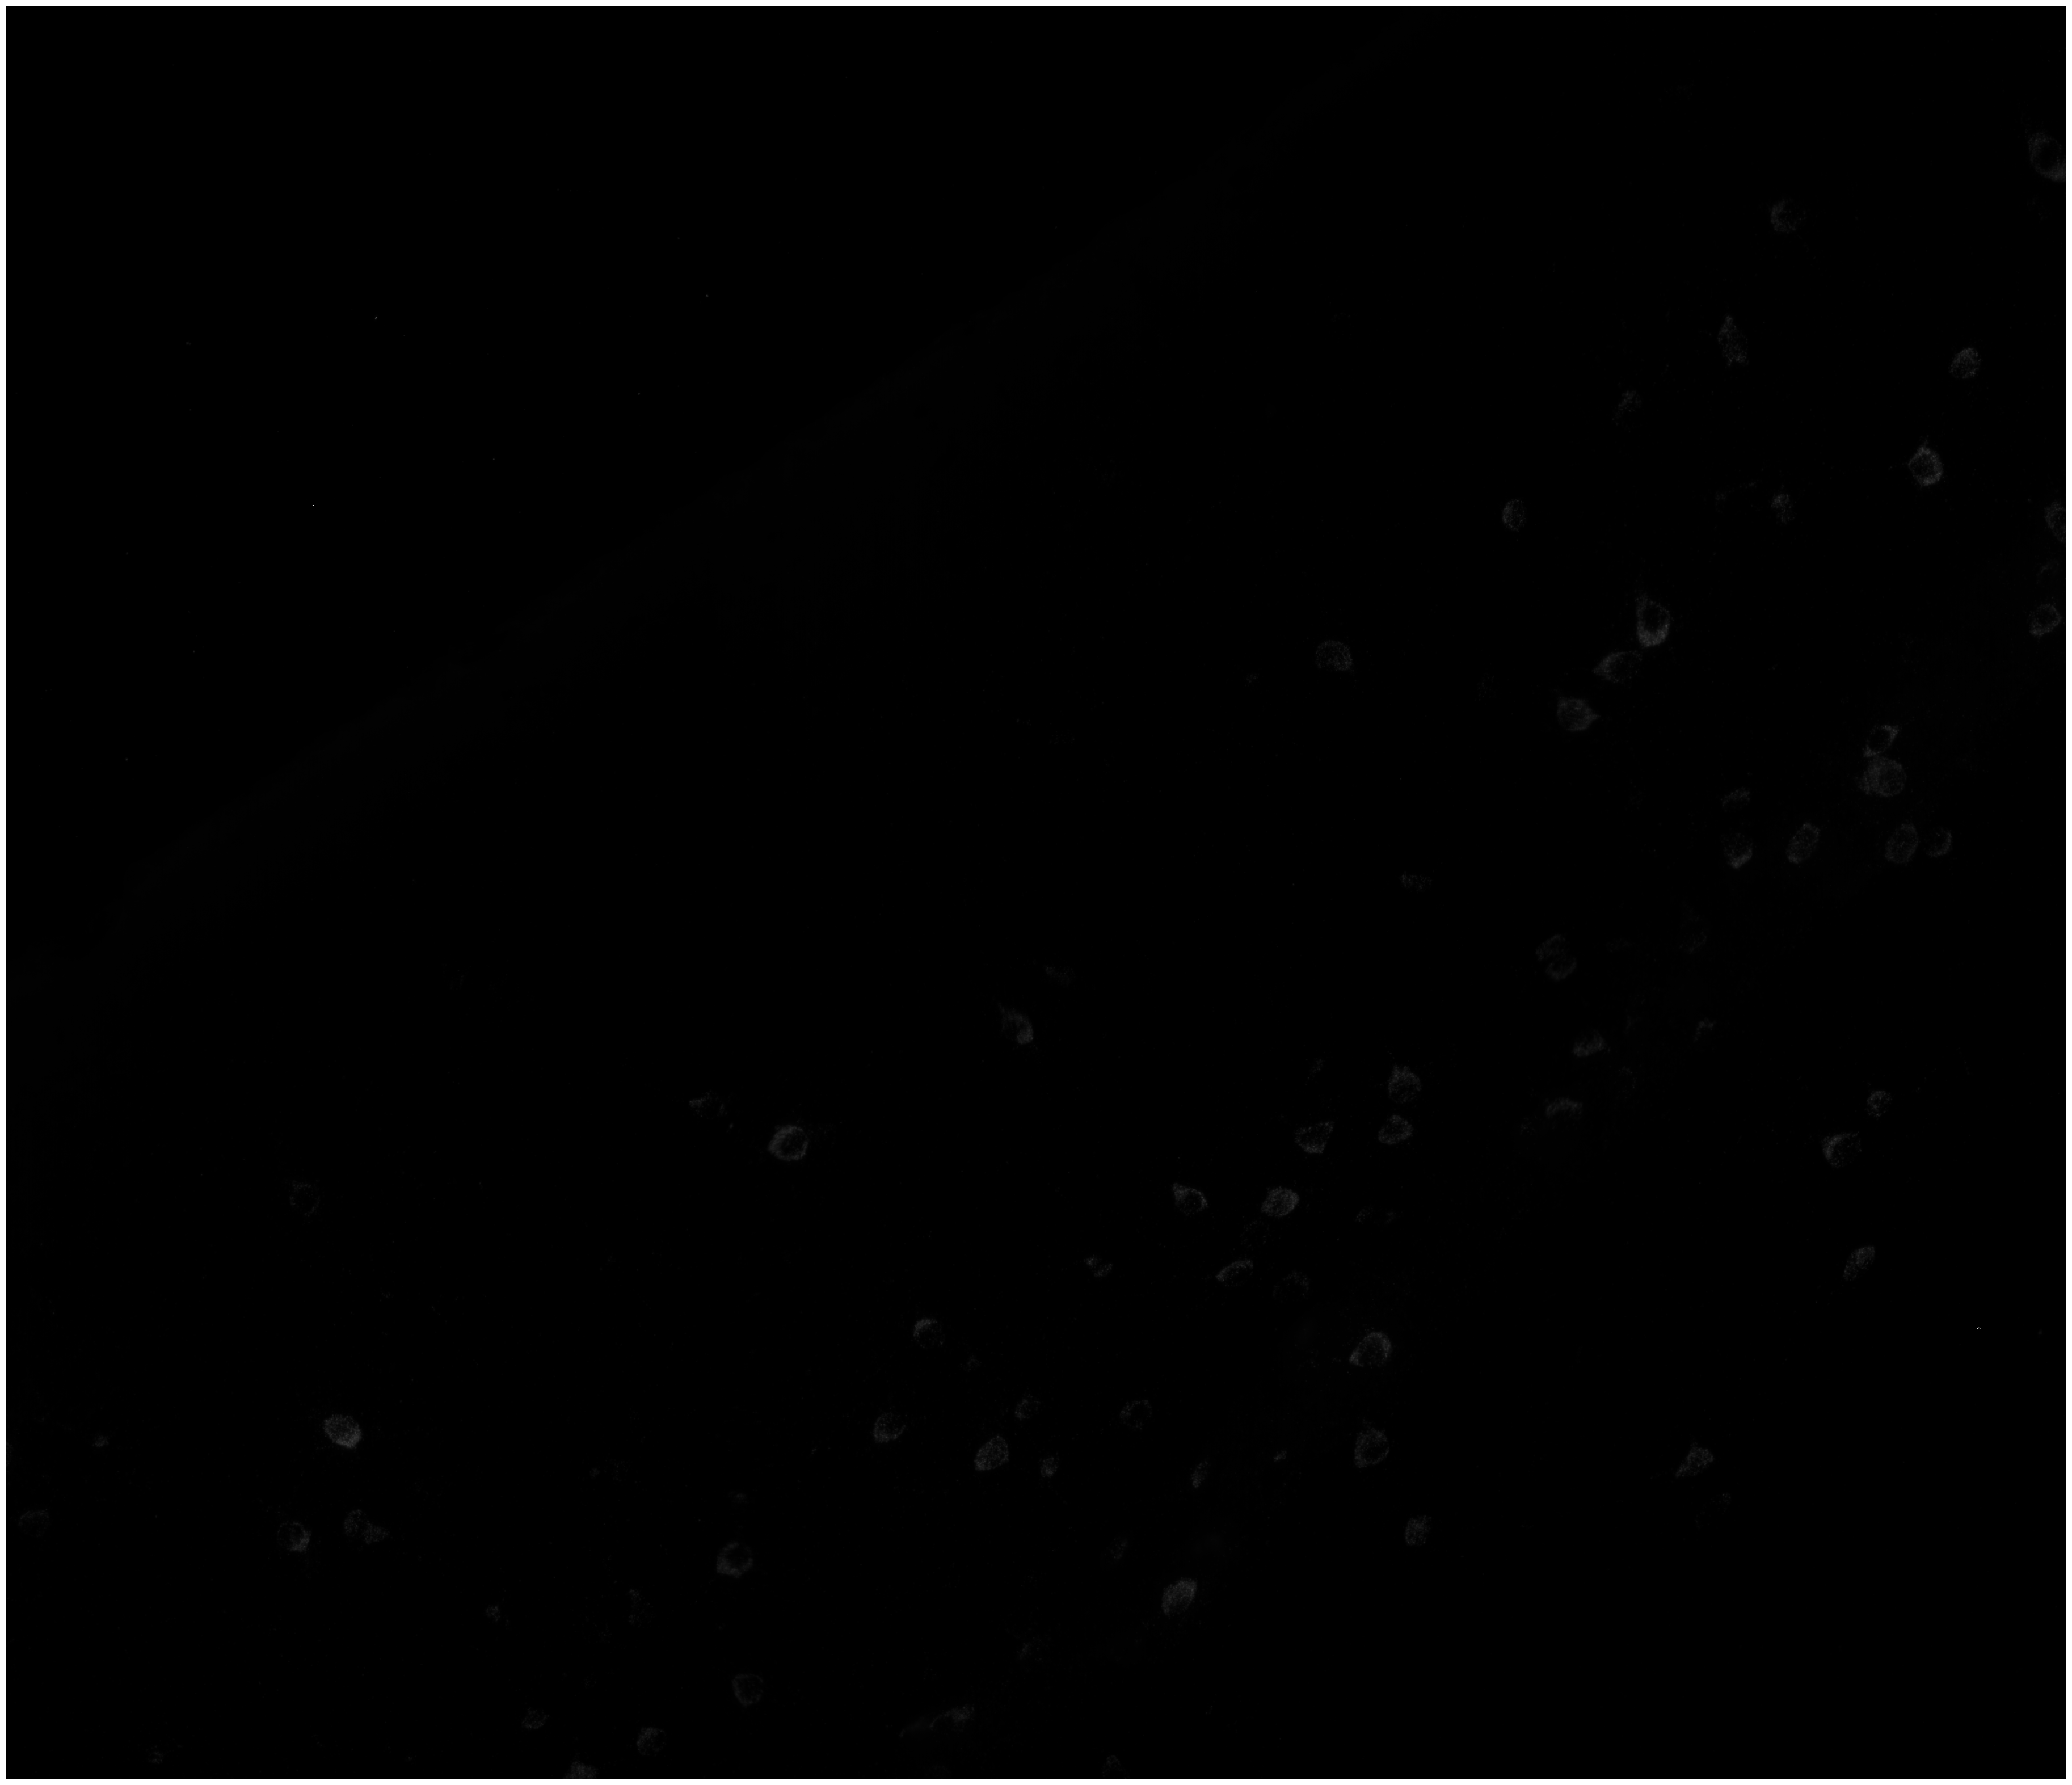

In [20]:
# img.show(layer = 'img1')

plot_img_layer(
    img,
    'img1',
    show=True,
    dpi=100,
    save_path=f"{out_path}/raw_{omero_id}_{roi_id}_{gene}.png"
)

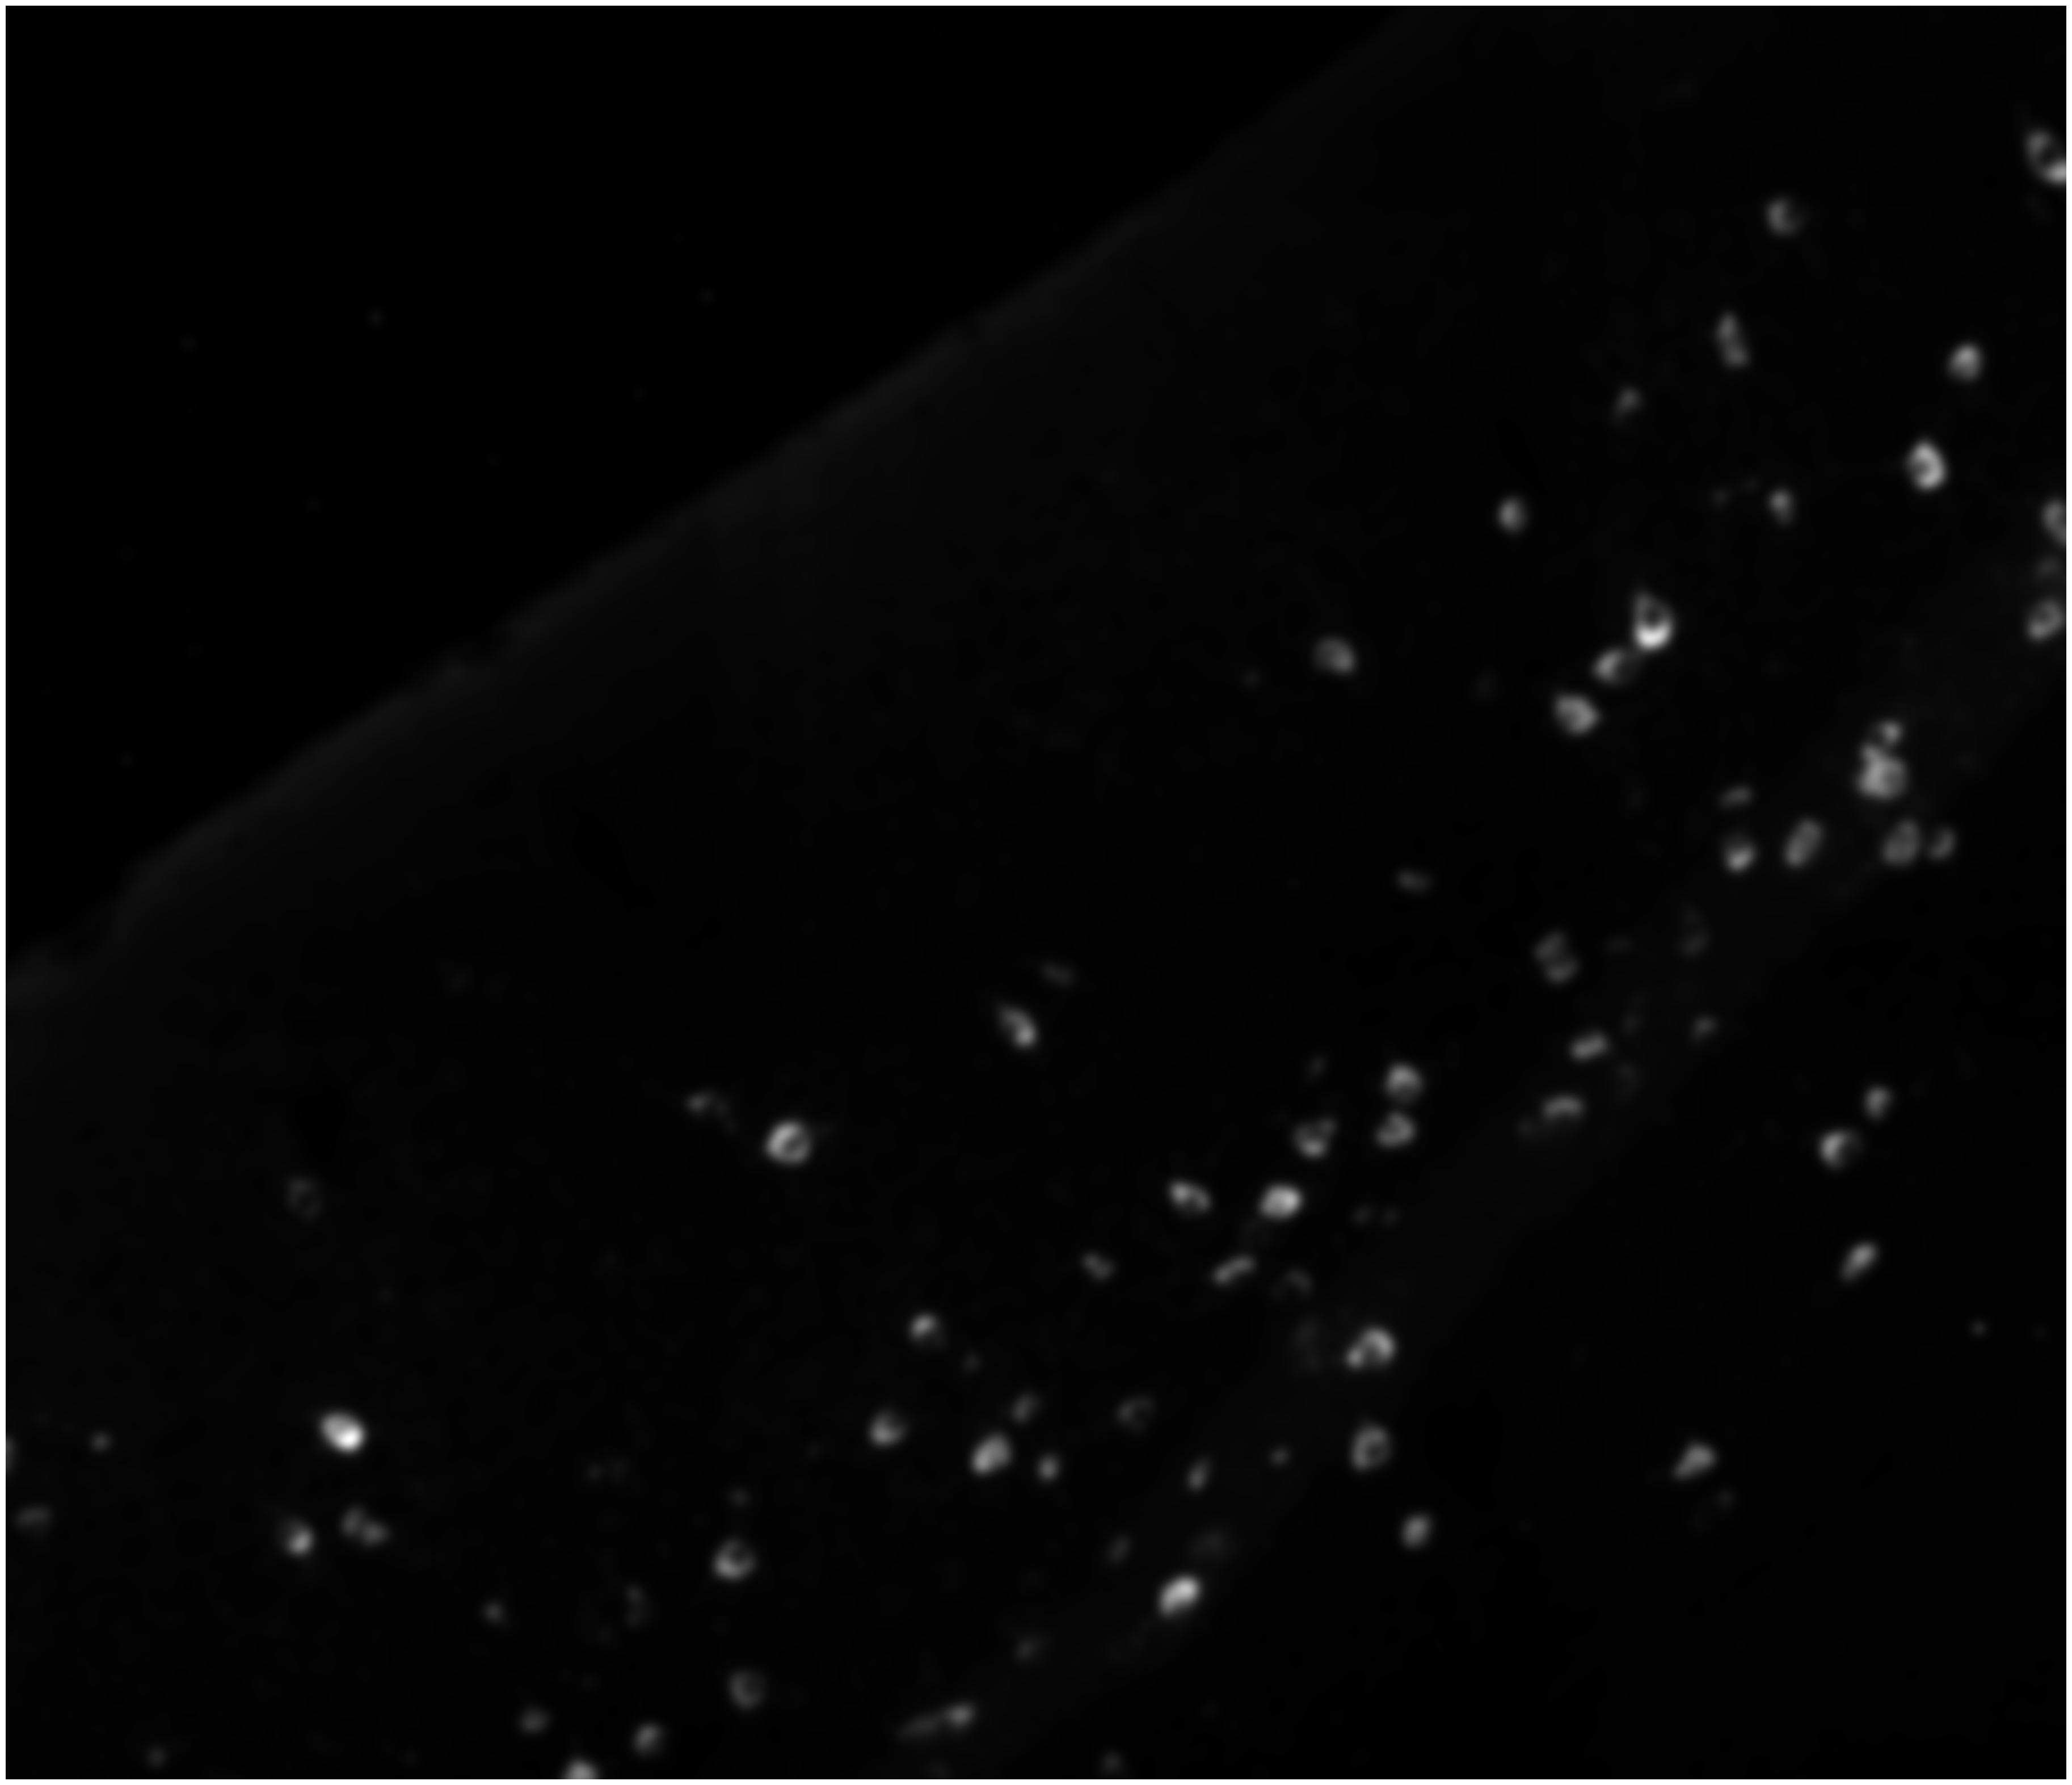

In [21]:


arr = _to_numpy_hwC(img, "img1")
enhanced = blur_and_boost_contrast(arr, sigma=10, stretch=False)
_add_layer_from_hwC(img, enhanced, "image_blur")
# img.show(layer='image_blur')


plot_img_layer(
    img,
    'image_blur',
    show=True,
    dpi=100,
    save_path=f"{out_path}/gaussian_{omero_id}_{roi_id}_{gene}.png"
)

In [22]:

sq.im.segment(
    img=img,
    layer="image_blur",
    layer_added="segmented_watershed_blur",
    method="watershed",
    # thresh=100,
    # greq=True,
    channel=0,
)

arr, labels, feature_df = extract_arr_to_df(img,  img_layer="image_blur", seg_layer="segmented_watershed_blur", area_percentile=0.50)

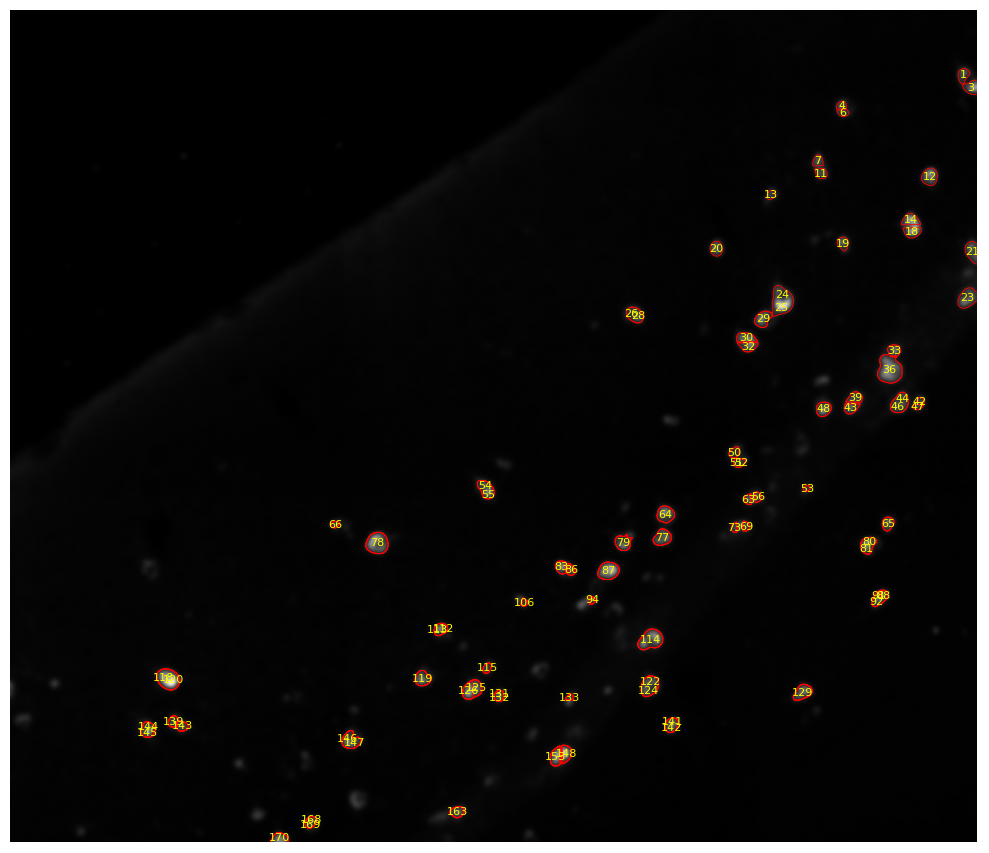

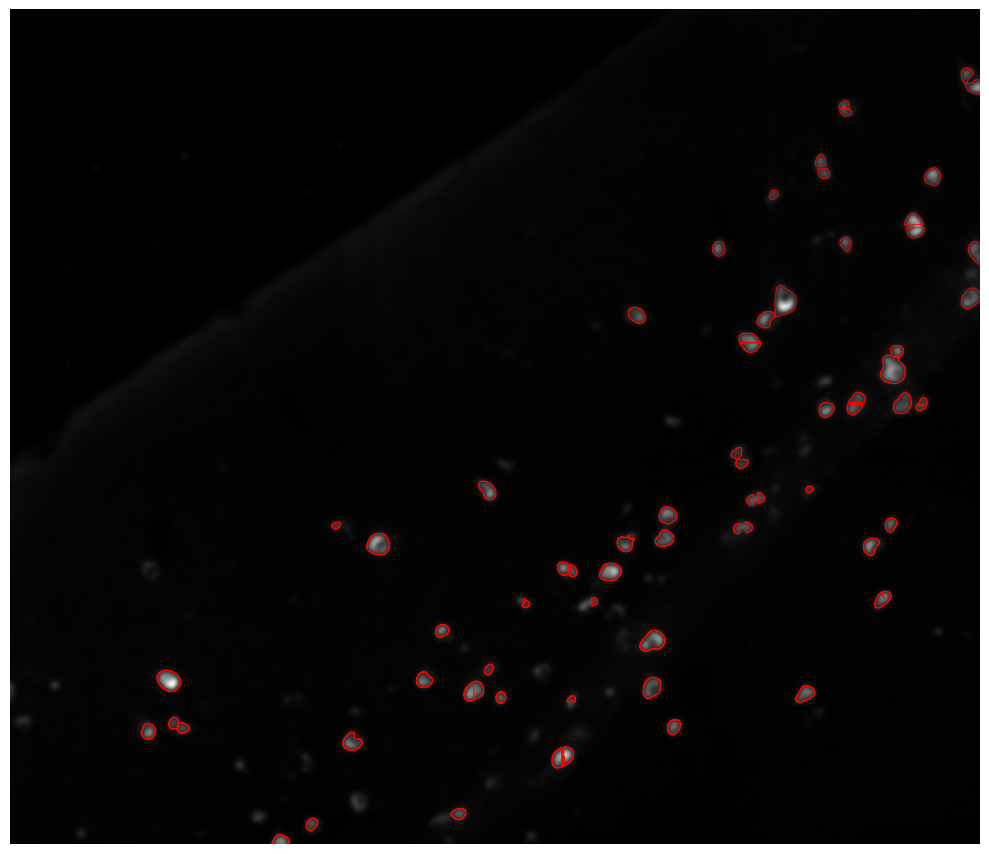

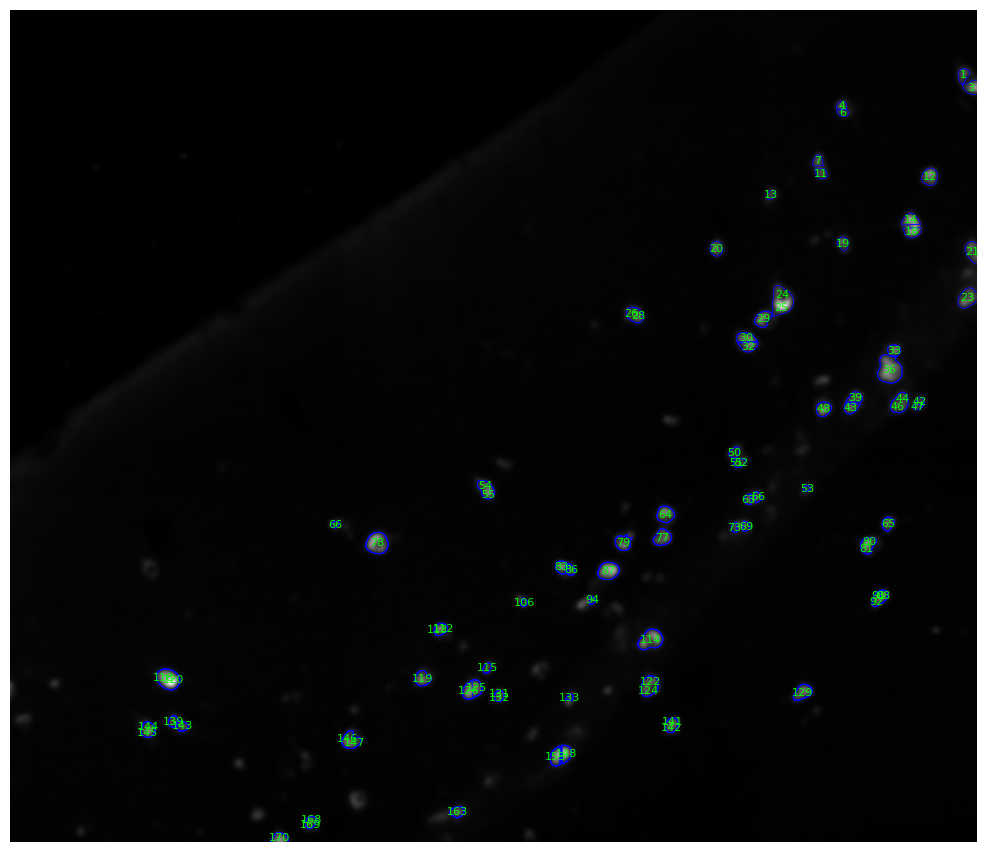

In [23]:
# Show grayscale DAPI channel with red contours and yellow labels
plot_segmentation_overlay(arr, labels, channel_to_show=0)

# Show color image (if multi-channel RGB) with no labels
plot_segmentation_overlay(arr, labels, use_color=True, show_labels=False)

# Show only first 100 labels, blue contours, green label text
plot_segmentation_overlay(arr, labels, contour_color="blue", label_color="lime", save_path=f"{out_path}/cellcellpose_gaussian_before_merge_{omero_id}_{roi_id}_{gene}.png")#, max_labels=100)


/var/folders/qt/wlfwvjyn6zn84sfygh5548qm0000gq/T/ipykernel_24018/2727514883.py:490: UserWarning: Rasterization of '<matplotlib.contour.QuadContourSet object at 0x17d296350>' will be ignored
  contour.set_rasterized(True)


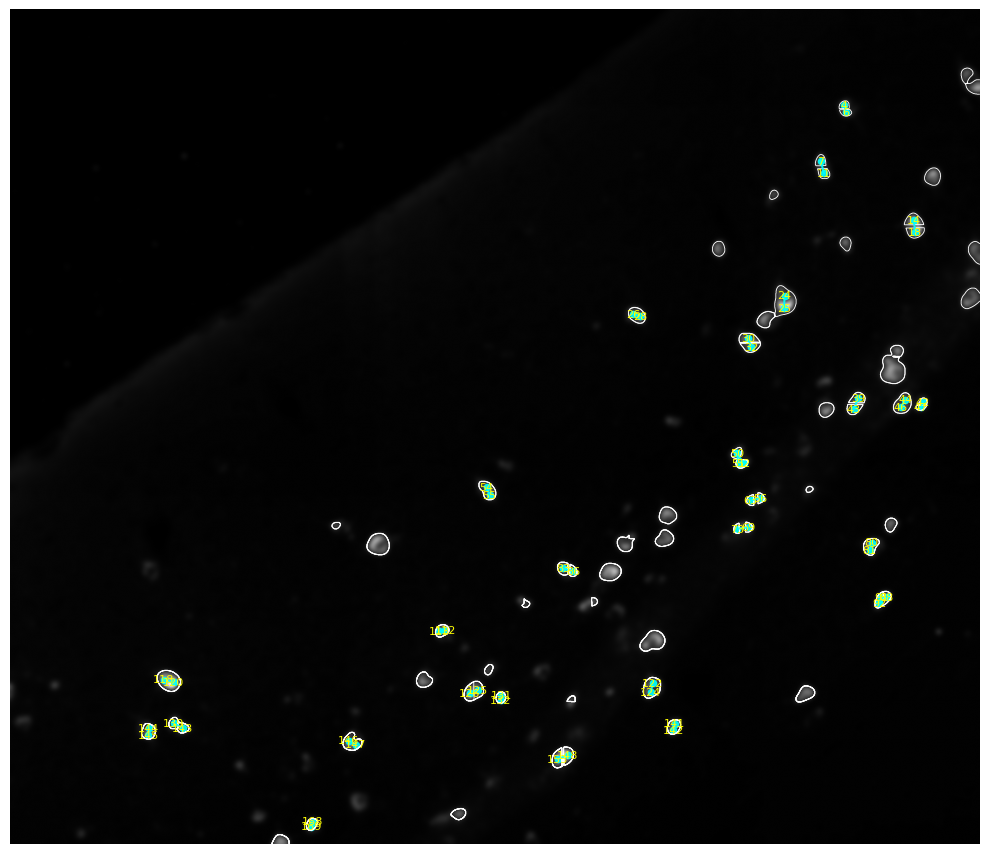

In [24]:
suggestions = suggest_label_merges(
    labels,
    max_distance=50,   # pixels
    min_area=10
)

plot_merge_suggestions(
    arr,
    labels,
    suggestions,
    channel_to_show=0,
    max_pairs=len(suggestions), 
    save_path=f"{out_path}/cellcellpose_gaussian_merge_suggestions_{omero_id}_{roi_id}_{gene}.png"
    # avoid clutter
)


In [26]:
pairs = suggestions[["label_1", "label_2"]].values.tolist()

pairs

[[131, 132],
 [51, 52],
 [168, 169],
 [88, 91],
 [42, 47],
 [112, 113],
 [141, 142],
 [91, 92],
 [144, 145],
 [26, 28],
 [4, 6],
 [80, 81],
 [146, 147],
 [125, 126],
 [54, 55],
 [30, 32],
 [122, 124],
 [44, 46],
 [88, 92],
 [118, 120],
 [139, 143],
 [56, 63],
 [83, 86],
 [50, 51],
 [148, 153],
 [39, 43],
 [69, 73],
 [50, 52],
 [14, 18],
 [24, 25],
 [7, 11]]

In [27]:
bad_pairs = [

]

pairs = [p for p in pairs if set(p) not in bad_pairs]
pairs.append([104, 107])

In [28]:

labels_new, feature_df_new = merge_label_groups(
    arr,
    labels,
    feature_df,
    merge_groups=pairs
)

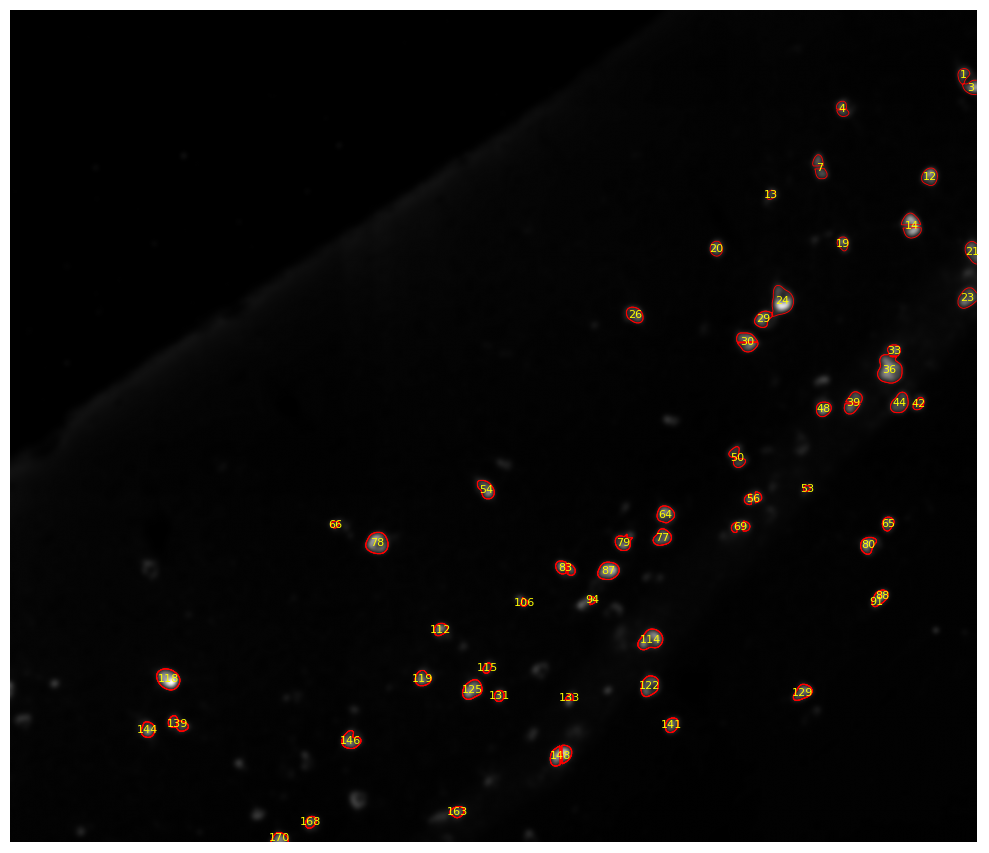

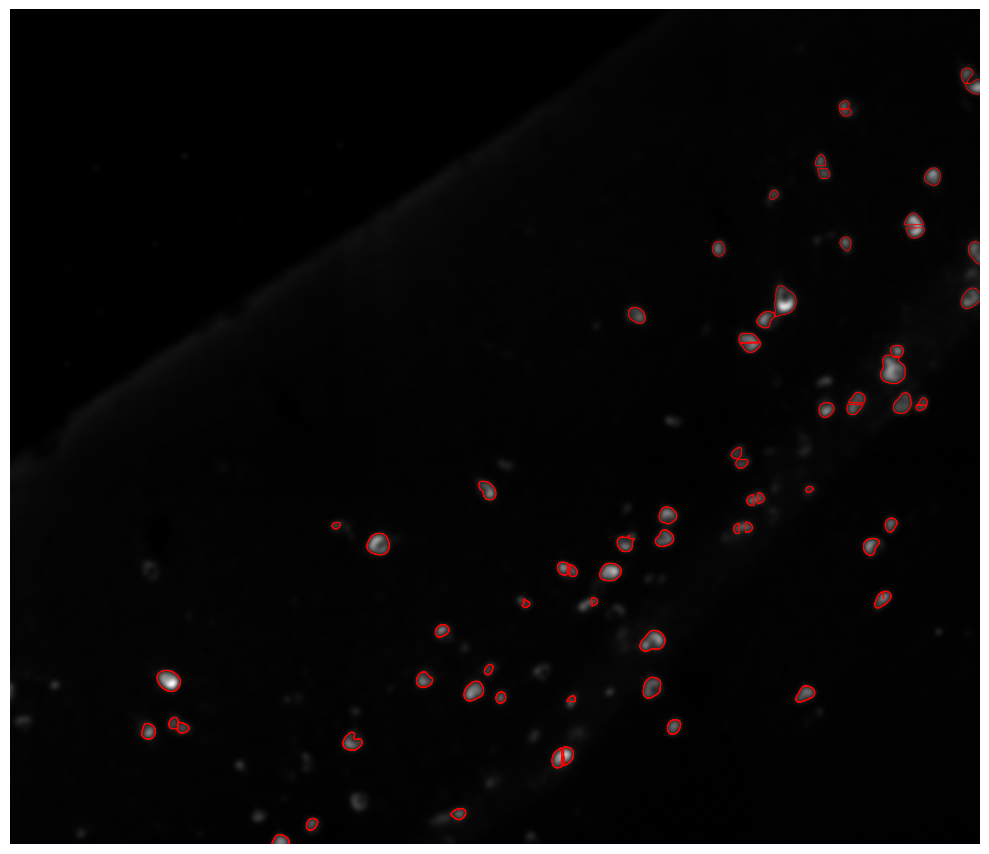

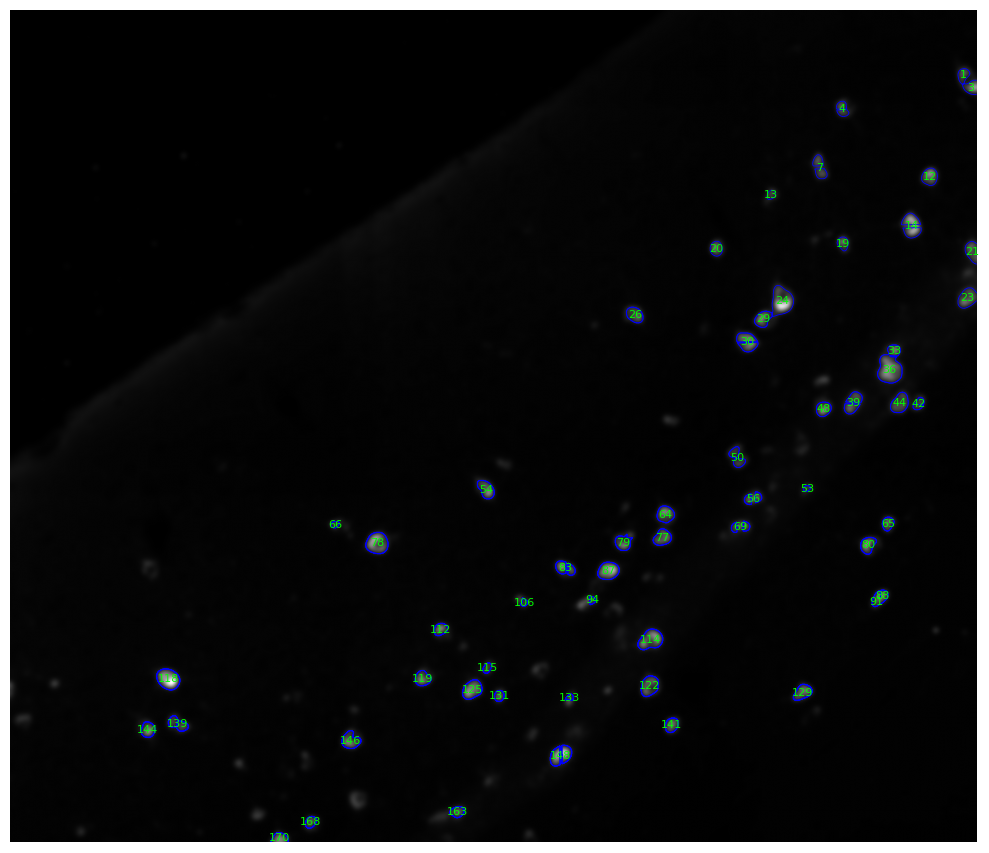

In [29]:
# Show grayscale DAPI channel with red contours and yellow labels
plot_segmentation_overlay(arr, labels_new, channel_to_show=0)

# Show color image (if multi-channel RGB) with no labels
plot_segmentation_overlay(arr, labels_new, use_color=True, show_labels=False)

# Show only first 100 labels, blue contours, green label text
plot_segmentation_overlay(arr, labels_new, contour_color="blue", label_color="lime", max_labels=100, 
                          save_path=f"{out_path}/cellcellpose_gaussian_{omero_id}_{roi_id}_{gene}.png")


In [30]:
feature_df['omero_id'] = omero_id
feature_df['roi_id']  = roi_id
feature_df['channel']  = gene
feature_df.to_csv(f"{out_path}/cellcellpose_gaussian_{omero_id}_{roi_id}_{gene}.csv")